In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/EEGMap/EEGMapTimeseries_10F_1S.npy')
labels = np.load('./datasets/EEGMap/EEGMapTimeseries_10F_1S_Labels.npy')
print(dataset.shape) # (sample, time, height, width, channel)
print(labels.shape)

(1785, 10, 24, 24, 3)
(1785,)


In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

shuf_dataset, shuf_labels = shuffle(dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 1249, Val set size: 268, Test set size: 268
(1249,)
(1249, 10, 24, 24, 3)


In [ ]:
"""
    Model and train
"""

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, SpatialDropout3D
from keras.layers import Conv3D, MaxPool3D
from keras.layers import Reshape, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'CRNN_EEGMapTimeseries.json'
weight_name = 'CRNN_EEGMapTimeseries_tmp.h5'

batch_size = 128
epochs = 64
num_classes = 2

print("Constructing MLP Model: ...", end='')
model = Sequential() # input (None, 10, 24, 24, 3)
model.add(Conv3D(8, kernel_size=4, padding='same', input_shape= X_train.shape[1:])) # (None, 10, 24, 24, 8)
model.add(Activation('relu'))
model.add(Conv3D(8, kernel_size=4, padding='same')) # (None, 10, 24, 24, 8)
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))# (None, 10, 12, 12, 8)
model.add(SpatialDropout3D(rate=0.01))

model.add(Conv3D(8, kernel_size=4, padding='same', input_shape= X_train.shape[1:])) # (None, 10, 12, 12, 8)
model.add(Activation('relu'))
model.add(Conv3D(8, kernel_size=4, padding='same')) # (None, 10, 12, 12, 8)
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))# (None, 10, 6, 6, 8)
model.add(SpatialDropout3D(rate=0.01))

model.add(Conv3D(16, kernel_size=4, padding='same')) # (None, 10, 6, 6, 16)
model.add(Activation('relu'))
model.add(Conv3D(16, kernel_size=4, padding='same')) # (None, 10, 6, 6, 16)
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))# (None, 10, 3, 3, 16)
model.add(SpatialDropout3D(rate=0.01))

# convert to RNN
model.add(Reshape(target_shape=(10, -1)))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.01))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.05))
model.add(Dense(1, activation='sigmoid'))

model.summary()
print(" Complete.")

print("Compiling MLP Model: ...", end='')
optimizer = Adam(lr=0.001)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

earlyStop = EarlyStopping(monitor='val_loss', patience=12, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[earlyStop, mcp_save, reduce_lr_loss], validation_data=(X_val, y_val), shuffle=True)
print("Complete.")

Constructing MLP Model: ..._________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 10, 24, 24, 8)     1544      
_________________________________________________________________
activation_8 (Activation)    (None, 10, 24, 24, 8)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 10, 24, 24, 8)     4104      
_________________________________________________________________
activation_9 (Activation)    (None, 10, 24, 24, 8)     0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 12, 12, 8)     0         
_________________________________________________________________
spatial_dropout3d_4 (Spatial (None, 10, 12, 12, 8)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 12, 12, 8

In [4]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'CRNN_EEGMapTimeseries.json'
weight_name = 'CRNN_EEGMapTimeseries.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

In [5]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CRNN_EEGMapTimeseries_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
#plt.ylim((0.05,1.05))
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Timeseries EEG Maps [1-50 Hz] CRNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

268/268 [==============================] - 4s 15ms/step

Final test acc: 82.84%


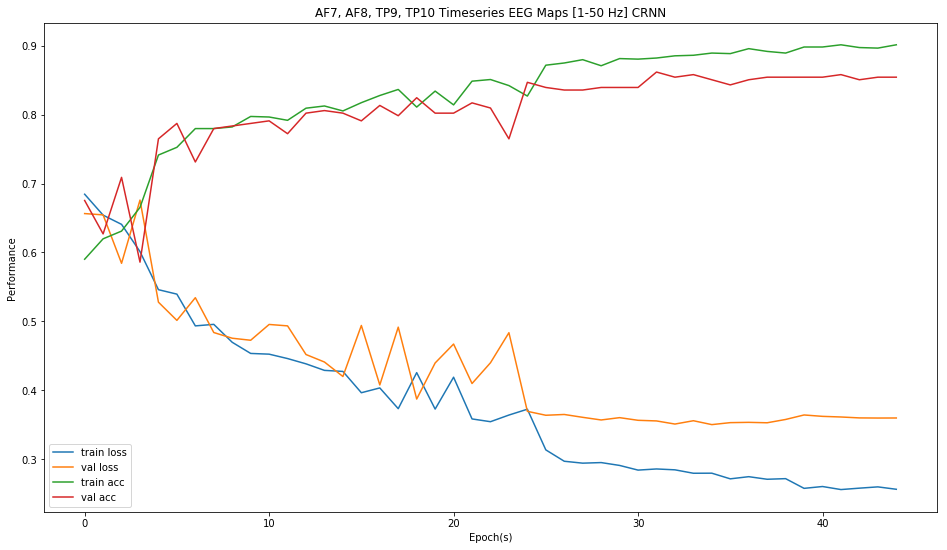

In [6]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CRNN_EEGMapTimeseries_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Timeseries EEG Maps [1-50 Hz] CRNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [8]:
"""
    Try fetching the model
"""

from keras.models import model_from_json

model_path = './models/'
json_name = 'CRNN_EEGMapTimeseries.json'
weight_name = 'CRNN_EEGMapTimeseries.h5'

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

268/268 [==============================] - 5s 17ms/step

Final test acc: 82.84%
